In [28]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model
from sklearn.ensemble import GradientBoostingClassifier
## for explainer
from lime import lime_tabular
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [9]:
df_data = pd.read_pickle('fullCleanedData.pkl')

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [11]:
#remove scroll
df_data_without_scroll = df_data.loc[df_data["type"] !="scroll"]
df_data_without_scroll.head()

,elementId,timeStamp,type,siteName,clientX,clientY,session,height,width,browser,key,sitename,real_date
31206,12,0.0,514,TestEinfach,614.857006,614.857006,f8b87dd1-ee10-f939-8561-a8622504f872,635.0,375,NaN,Backspace,NaN,4.783890
26125,11,424832.5,510,TestSchwer,194.000000,194.000000,41f22727-0a74-d41b-d6c2-29936806a037,358.0,360,NaN,NaN,NaN,4.755718
8443,11,219164.7,514,TestEinfach,614.857006,614.857006,67cc623a-295c-f6e0-67bc-c6f312d942ce,1304.0,2117,NaN,Backspace,NaN,1.701700
14138,17,94014.0,512,TestSchwer,614.857006,614.857006,36e6c57d-0872-8c05-e643-b2491fe5c9cd,1217.0,1440,Chrome,NaN,TestSchwer,1.937664
10550,12,976685.0,511,TestSchwer,418.000000,418.000000,90ab4d9b-1f2b-12d8-0607-da60d299f472,866.0,1439,NaN,NaN,NaN,1.714962


In [12]:
df_einfach = pd.DataFrame(df_data_without_scroll.loc[df_data_without_scroll['siteName']=='TestEinfach'])
df_schwer = pd.DataFrame(df_data_without_scroll.loc[df_data_without_scroll['siteName']=='TestSchwer'])

In [13]:
df_einfach.head()

,elementId,timeStamp,type,siteName,clientX,clientY,session,height,width,browser,key,sitename,real_date
31206,12,0.0,514,TestEinfach,614.857006,614.857006,f8b87dd1-ee10-f939-8561-a8622504f872,635.0,375,NaN,Backspace,NaN,4.783890
8443,11,219164.7,514,TestEinfach,614.857006,614.857006,67cc623a-295c-f6e0-67bc-c6f312d942ce,1304.0,2117,NaN,Backspace,NaN,1.701700
14701,11,96130.5,514,TestEinfach,614.857006,614.857006,d5c86034-0991-2594-ca59-fa08c4fb3112,1304.0,3440,NaN,Backspace,NaN,1.960783
9132,12,39193.6,514,TestEinfach,614.857006,614.857006,b0c22fd2-b15b-4344-eaa2-634377cb1ff9,1295.0,2171,NaN,Backspace,NaN,1.705816
7436,19,994045.5,514,TestEinfach,614.857006,614.857006,69e4a6b4-0c82-f9be-c9d2-ea959fb5ac90,962.0,1724,NaN,Backspace,NaN,1.050133


In [14]:
# new sessionId 
import random
from random import choice
import collections

array_of_ids_einfach = df_einfach['session'].value_counts().index.tolist()
array_of_ids_schwer = df_schwer['session'].value_counts().index.tolist()
numbers_schwer = []

random_numbers_ids_einfach = random.sample(range(101,1000), len(array_of_ids_einfach))
for i in range(len(random_numbers_ids_einfach)):
    random_numbers_ids_schwer = random.choice([i for i in range(101, 1000) if i not in random_numbers_ids_einfach])
    numbers_schwer.append(random_numbers_ids_schwer)

numbers = random_numbers_ids_einfach + numbers_schwer

df_einfach['session'] = df_einfach['session'].replace(array_of_ids_einfach, random_numbers_ids_einfach)
df_schwer['session'] = df_schwer['session'].replace(array_of_ids_schwer, numbers_schwer)

print([item for item, count in collections.Counter(numbers).items() if count > 1])

[423]


In [15]:
df_data = pd.concat([df_einfach, df_schwer])

In [16]:
df_data['siteName'] = df_data['siteName'].replace('TestEinfach', 0)
df_data['siteName'] = df_data['siteName'].replace('TestSchwer', 1)

In [17]:
df_data = df_data.drop(['sitename', 'key', 'browser', 'elementId'], axis=1)

In [18]:
from sklearn.utils import shuffle
df_data = shuffle(df_data)

In [19]:
df_data.reset_index(inplace=True)

In [20]:
df_data.head()
# Das Ding ist, wir können nicht auf elementId predichten bzw. denen unterschiedliche Nummern geben, weil wir ja schon wissen ob ein Element auf der einen oder anderen Seite ist. Das heißt wir müssen alle elementIds entfernen 

,index,timeStamp,type,siteName,clientX,clientY,session,height,width,real_date
0,5040,214803.7,515,1,614.857006,614.857006,791,664.0,360,1.008412
1,19714,0.0,514,0,614.857006,614.857006,676,780.0,390,4.739677
2,9611,252729.1,511,1,635.000000,635.000000,889,667.0,1440,1.708154
3,6257,389144.7,511,1,1179.000000,1179.000000,342,1328.0,2560,1.028025
4,10480,845409.0,514,0,614.857006,614.857006,230,866.0,1439,1.713443


In [21]:
df_data.to_pickle('modelTrainingDataSet.pkl')

In [22]:
dataset = pd.read_pickle('modelTrainingDataSet.pkl')

In [23]:
siteName = 'siteName'

In [24]:
dataset = dataset.drop(['elementId'], axis=1)

KeyError: "['elementId'] not found in axis"

In [ ]:
dtf_train, dtf_test = model_selection.train_test_split(dataset,test_size=0.3)## print info
print("X_train shape:", dtf_train.drop("siteName",axis=1).shape, "| X_test shape:", dtf_test.drop("siteName",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["siteName"]),2), "| y_test mean:", round(np.mean(dtf_test["siteName"]),2))
print(dtf_train.shape[1], "features:", dtf_train.drop("siteName",axis=1).columns.to_list())


X_train shape: (6217, 9) | X_test shape: (2665, 9)
y_train mean: 0.68 | y_test mean: 0.68
10 features: ['index', 'timeStamp', 'type', 'clientX', 'clientY', 'session', 'height', 'width', 'real_date']


In [ ]:
from numpy import array
type_array = dtf_train['type']
values = array(type_array)

In [ ]:
dummy = pd.get_dummies(dtf_train["type"], prefix="type",drop_first=True)
dtf_train= pd.concat([dtf_train, dummy], axis=1)
print( dtf_train.filter(like="type", axis=1).head())
columndtf = dtf_train.drop("type", axis=1)

      type  type_511  type_512  type_513  type_514  type_515
3121   511         1         0         0         0         0
6868   514         0         0         0         1         0
3832   510         0         0         0         0         0
216    512         0         1         0         0         0
6890   514         0         0         0         1         0


In [ ]:
#die features skalieren bessere Verteilung
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(dtf_train.drop("siteName", axis=1))
dtf_scaled= pd.DataFrame(X, columns=dtf_train.drop("siteName", axis=1).columns, index=dtf_train.index)
dtf_scaled["siteName"] = dtf_train["siteName"]
dtf_scaled.head()


,index,timeStamp,type,clientX,clientY,session,height,width,real_date,type_511,type_512,type_513,type_514,type_515,siteName
3121,0.351351,0.001158,0.2,0.493112,0.493112,0.650901,0.660920,0.363312,0.094016,1.0,0.0,0.0,0.0,0.0,1
6868,0.773311,0.123893,0.8,0.275467,0.275467,0.331081,0.097701,0.016883,0.460007,0.0,0.0,0.0,1.0,0.0,0
3832,0.431419,0.013095,0.0,0.265558,0.265558,0.650901,0.660920,0.363312,0.093990,0.0,0.0,0.0,0.0,0.0,1
216,0.024212,0.004652,0.4,0.275467,0.275467,0.862613,0.383780,0.506494,0.193710,0.0,1.0,0.0,0.0,0.0,1
6890,0.775788,0.029595,0.8,0.275467,0.275467,0.147523,0.650064,0.587987,0.165234,0.0,0.0,0.0,1.0,0.0,0


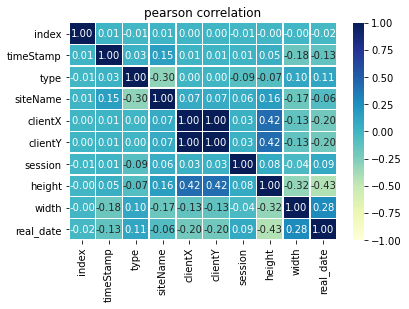

In [ ]:
#die helleren Stellen können interessant sein, da der Pearson Wert recht niedrig ist
corr_matrix = dataset.copy()
for col in corr_matrix.columns:    
    if corr_matrix[col].dtype == "O":         
        corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
        corr_matrix = corr_matrix.corr(method="pearson")
        sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
        plt.title("pearson correlation")

In [ ]:
X = dtf_train.drop("Y", axis=1).valuesy = dtf_train["Y"].valuesfeature_names = dtf_train.drop("Y", axis=1).columns.tolist()## Importancemodel = ensemble.RandomForestClassifier(n_estimators=100,                      criterion="entropy", random_state=0)model.fit(X,y)importances = model.feature_importances_## Put in a pandas dtfdtf_importances = pd.DataFrame({"IMPORTANCE":importances,             "VARIABLE":feature_names}).sort_values("IMPORTANCE",             ascending=False)dtf_importances['cumsum'] =              dtf_importances['IMPORTANCE'].cumsum(axis=0)dtf_importances = dtf_importances.set_index("VARIABLE")    ## Plotfig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)fig.suptitle("Features Importance", fontsize=20)ax[0].title.set_text('variables')    dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(                kind="barh", legend=False, ax=ax[0]).grid(axis="x")ax[0].set(ylabel="")ax[1].title.set_text('cumulative')dtf_importances[["cumsum"]].plot(kind="line", linewidth=4,                                  legend=False, ax=ax[1])ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)),           xticklabels=dtf_importances.index)plt.xticks(rotation=70)plt.grid(axis='both')plt.show()


### Random Forest

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = dataset[['type', 'timeStamp','height', 'width']]
Y = dataset['siteName']

X = StandardScaler().fit_transform(X)

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.30, 
                                                    random_state = 101)

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_Train,Y_Train)

y_pred=clf.predict(X_Test)

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_Test, y_pred))

Accuracy: 0.9369606003752345


In [ ]:
# das ist ja dann eigentlich nur ein Event, das wollen wir ja nicht predicten sondern eine Session
clf.predict([[510, 0, 920, 200]])

array([1])

### SVM

In [ ]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_Train, Y_Train)

#Predict the response for test dataset
y_pred = clf.predict(X_Test)

In [ ]:
from sklearn.svm import LinearSVC

clf2 = LinearSVC(C=1.0, loss='hinge', class_weight='balanced')

clf2.fit(X_Train, Y_Train)

print('Done')

NameError: name 'X_Train' is not defined

In [ ]:
from sklearn.metrics import accuracy_score

y_test_pred = clf.predict(X_Test)
y_train_pred = clf.predict(X_Train)

print(f'Classifier: {clf.__class__}\n')

print('Accuracy Summary')
print('================')

print(f'Test:    {accuracy_score(Y_Test, y_test_pred)*100:6.2f}%')
print(f'Train:   {accuracy_score(Y_Train, y_train_pred)*100:6.2f}%')

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_Test, y_pred))

Accuracy: 0.7215759849906191


In [ ]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(Y_Test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(Y_Test, y_pred))

Precision: 0.77947932618683
Recall: 0.8312465977136636


# Sessions

In [245]:
df_sessions = pd.read_pickle('SortedBySessions.pkl')

In [246]:
df_sessions.head()

,session,count_mouseover,count_mouseout,count_click,count_blur,count_focus,count_keydown,duration,height,width,siteName
0,512,7,7,0,7,7,4,18.157,664,390,0
1,518,70,70,25,31,32,13,459.177,667,1440,1
2,519,6,6,0,7,7,0,18.090,775,412,0
3,520,39,39,3,14,13,29,232.459,1217,1440,1
4,538,8,8,4,17,15,20,213.904,664,390,1


In [247]:
X_session = df_sessions[['count_mouseover', 'count_mouseout','count_click','count_blur','count_keydown','count_focus','duration']]
Y_session = df_sessions['siteName']

X_session = StandardScaler().fit_transform(X_session)

X_session_Train, X_session_Test, Y_session_Train, Y_session_Test = train_test_split(X_session, Y_session, test_size = 0.30, 
                                                    random_state = 101)

#### Random Forest Session

Accuracy: 0.8974358974358975

With Hyperparameter: Accuracy: 0.9230769230769231


In [253]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
forest_model=RandomForestClassifier(n_estimators=250)

#Train the model using the training sets y_pred=clf.predict(X_test)
forest_model.fit(X_session_Train,Y_session_Train)

y_session_pred=forest_model.predict(X_session_Test)

In [254]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_session_Test, y_session_pred))

Accuracy: 0.8974358974358975


#### Improve Random Forest with Hyperparameter

In [107]:
rfc_model = RandomForestClassifier()

parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None]
    
}

In [108]:
from sklearn.model_selection import GridSearchCV
cv_grid = GridSearchCV(rfc_model,parameters,cv=5)
cv_grid.fit(X_session, Y_session.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 8, 16, 32, None],
                         'n_estimators': [5, 10, 50, 100, 250]})

In [109]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [110]:
display(cv_grid)

Best parameters are: {'max_depth': 16, 'n_estimators': 10}


0.836 + or -0.078 for the {'max_depth': 2, 'n_estimators': 5}
0.899 + or -0.039 for the {'max_depth': 2, 'n_estimators': 10}
0.899 + or -0.048 for the {'max_depth': 2, 'n_estimators': 50}
0.867 + or -0.082 for the {'max_depth': 2, 'n_estimators': 100}
0.868 + or -0.059 for the {'max_depth': 2, 'n_estimators': 250}
0.875 + or -0.041 for the {'max_depth': 4, 'n_estimators': 5}
0.93 + or -0.015 for the {'max_depth': 4, 'n_estimators': 10}
0.899 + or -0.052 for the {'max_depth': 4, 'n_estimators': 50}
0.915 + or -0.015 for the {'max_depth': 4, 'n_estimators': 100}
0.915 + or -0.015 for the {'max_depth': 4, 'n_estimators': 250}
0.922 + or -0.034 for the {'max_depth': 8, 'n_estimators': 5}
0.922 + or -0.024 for the {'max_depth': 8, 'n_estimators': 10}
0.915 + or -0.038 for the {'max_depth': 8, 'n_estimators': 50}
0.915 + or -0.038 for the {'max_depth': 8, 'n_estimators': 100}
0.915 + or -0.038 for the {'max_depth': 8, 'n_estimators

#### KNN

In [75]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=3)

knn_model.fit(X_session_Train, Y_session_Train)

y_knn_pred = knn_model.predict(X_session_Test) # 0:Overcast, 2:Mild


In [76]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_session_Test, y_knn_pred))

Accuracy: 0.8717948717948718


Robust Scaling to improve KNN --> Accuracy: 0.8717948717948718

MinMax Scaling to improve KNN --> Accuracy: 0.8461538461538461

In [90]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_session_robust = df_sessions[['count_mouseover', 'count_mouseout','count_click','count_blur','count_keydown','count_focus','duration','height', 'width']]
Y_session_robust = df_sessions['siteName']

X_session_robust = scaler.fit_transform(X_session_robust)

X_session_robust_Train, X_session_robust_Test, Y_session_robust_Train, Y_session_robust_Test = train_test_split(X_session_robust, Y_session_robust, test_size = 0.30, random_state = 101)

#Create KNN Object
knn_robust = KNeighborsClassifier()

knn_robust.fit(X_session_robust_Train, Y_session_robust_Train)

y_knn_pred_robust = knn_robust.predict(X_session_robust_Test)

print("Accuracy:",metrics.accuracy_score(Y_session_robust_Test, y_knn_pred_robust))

Accuracy: 0.8461538461538461


Use Hyperparameter

In [91]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]

hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

hyper_model = GridSearchCV(knn_model, hyperparameters, cv=10)
best_model = hyper_model.fit(X_session_Train,Y_session_Train)

print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])


Best leaf_size: 1
Best p: 1
Best n_neighbors: 1


In [93]:
y_hyper_pred = best_model.predict(X_session_Test)
print("Accuracy:",metrics.accuracy_score(Y_session_Test, y_hyper_pred))

Accuracy: 0.7948717948717948


#### Linear Discriminat Analysis

In [48]:
from sklearn.datasets import make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_session_Train, Y_session_Train)

LinearDiscriminantAnalysis()

In [49]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = cross_val_score(lda_model, X_session, Y_session, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))   


0.8502136752136753


#### Logistic Regression

In [51]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg_model = LogisticRegression(random_state=16)

# fit the model with data
logreg_model.fit(X_session_Train, Y_session_Train)

y_logreg_pred = logreg_model.predict(X_session_Test)

In [52]:
print("Accuracy:",metrics.accuracy_score(Y_session_Test, y_logreg_pred))

Accuracy: 0.8205128205128205


#### Naive Bayes

In [77]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb_model = GaussianNB()

#Train the model using the training sets
gnb_model.fit(X_session_Train, Y_session_Train)

#Predict the response for test dataset
y_gnb_pred = gnb_model.predict(X_session_Test)

In [78]:
print("Accuracy:",metrics.accuracy_score(Y_session_Test, y_gnb_pred))

Accuracy: 0.7435897435897436


#### SVM

In [80]:
from sklearn import svm
#Create a svm Classifier
svm_model = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
svm_model.fit(X_session_Train, Y_session_Train)

#Predict the response for test dataset
y_svm_pred = svm_model.predict(X_session_Test)

In [81]:
print("Accuracy:",metrics.accuracy_score(Y_session_Test, y_svm_pred))

Accuracy: 0.8205128205128205


#### Gradient Boosting

In [82]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_booster_model = GradientBoostingClassifier(learning_rate=0.1)
gradient_booster_model.fit(X_session_Train,Y_session_Train)

y_gradient_pred = gradient_booster_model.predict(X_session_Test)


In [83]:
print("Accuracy:",metrics.accuracy_score(Y_session_Test, y_gradient_pred))

Accuracy: 0.8461538461538461


#### ANN / Multi-Layer-Perceptron
Batch-Size: 32 loss: 0.6364 - accuracy: 0.7333

Batch-Size: 16 loss: 0.5102 - accuracy: 0.8444

Batch-Size: 8  loss: 0.3590 - accuracy: 0.8556

Batch-Size: 32 and epochs: 100 loss: 0.6783 - accuracy: 0.7333


In [179]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
import tensorflow as tf

In [187]:
ann_model = tf.keras.models.Sequential()
ann_model.add(tf.keras.layers.Dense(units=4,activation="relu"))
ann_model.add(tf.keras.layers.Dense(units=4,activation="relu"))
ann_model.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
ann_model.compile(optimizer="adam",loss="mean_squared_error",metrics=['accuracy'])
ann_model.fit(X_session_Train,Y_session_Train,batch_size=32,epochs = 50)

y_ann_pred=ann_model.predict(X_session_Test)

Epoch 1/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2319 - accuracy: 0.6667
Epoch 2/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2309 - accuracy: 0.6667
Epoch 3/50
3/3 [==============================] - 0s 3ms/step - loss: 0.2298 - accuracy: 0.6556
Epoch 4/50
3/3 [==============================] - 0s 13ms/step - loss: 0.2288 - accuracy: 0.6889
Epoch 5/50
3/3 [==============================] - 0s 3ms/step - loss: 0.2276 - accuracy: 0.7222
Epoch 6/50
3/3 [==============================] - 0s 3ms/step - loss: 0.2265 - accuracy: 0.7556
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 0.2254 - accuracy: 0.7667
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2242 - accuracy: 0.7667
Epoch 9/50
3/3 [==============================] - 0s 3ms/step - loss: 0.2232 - accuracy: 0.7667
Epoch 10/50
3/3 [==============================] - 0s 4ms/step - loss: 0.2219 - accuracy: 0.7667
Epoch 11/50
3/3 [=====================

# Sessions only mousedynamics

In [223]:
df_mouse = pd.read_pickle('CleanedDataWithIds.pkl') 

In [224]:
df_mouse = df_mouse.drop(['date', 'sitename', 'key', 'elementId', 'height', 'width', 'browser', ], axis=1)
df_mouse.head()

,timeStamp,type,siteName,clientX,clientY,session
339,824.2999999988824,mouseover,0,673,363,898
340,858.2999999988824,mouseout,0,772,333,898
341,2005.2999999988824,mouseover,0,796,266,898
342,2296.5,focus,0,NaN,NaN,898
343,2875.2999999988824,mouseover,0,995,264,898


In [228]:
df_mouseover = df_mouse.loc[df_mouse['type']=='mouseover']
df_mouseout = df_mouse.loc[df_mouse['type']=='mouseout']
df_mouse = pd.concat([df_mouseover, df_mouseout])

df_mouse['type'] = df_mouse['type'].replace('mouseover', 2)
df_mouse['type'] = df_mouse['type'].replace('mouseout', 3)
df_mouse['array'] = (640, 336)

df_mouse.head()

,timeStamp,type,siteName,clientX,clientY,session,array
0,NaN,NaN,NaN,NaN,NaN,NaN,640
1,NaN,NaN,NaN,NaN,NaN,NaN,336


In [220]:
X_mouse = df_mouse[['timeStamp', 'type','clientX', 'clientY', 'session', 'array']]
Y_mouse = df_mouse['siteName']

X_mouse = StandardScaler().fit_transform(X_mouse)

X_mouse_Train, X_mouse_Test, Y_mouse_Train, Y_mouse_Test = train_test_split(X_mouse, Y_mouse, test_size = 0.30, 
                                                    random_state = 101)

In [221]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
forest_model_mouse=RandomForestClassifier(n_estimators=250)

#Train the model using the training sets y_pred=clf.predict(X_test)
forest_model_mouse.fit(X_mouse_Train,Y_mouse_Train)

y_mouse_pred=forest_model_mouse.predict(X_mouse_Test)

In [222]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_mouse_Test, y_mouse_pred))

Accuracy: 0.967173738991193


# CNN Sequential Data Model

In [234]:
df_seq = pd.read_pickle('CleanedDataWithIds.pkl') 
df_seq['date'] = df_seq['date'].astype('datetime64[ns]')

In [236]:
df_seq= df_seq.sort_values(by=['session','date'], ascending=[False, True])
df_seq.head()


,elementId,timeStamp,type,siteName,date,clientX,clientY,session,height,width,browser,key,sitename
2388,inputHobby,2224.899999976158,mouseover,1,2022-10-18 12:41:25.264,233,286,997,520,360,NaN,NaN,NaN
2389,inputHobby,2241.699999988079,focus,1,2022-10-18 12:41:25.273,NaN,NaN,997,520,360,Chrome,NaN,NaN
2392,inputHobby,7932.899999976158,mouseout,1,2022-10-18 12:41:30.975,307,192,997,277,360,NaN,NaN,NaN
2393,inputHobby,7951.699999988079,blur,1,2022-10-18 12:41:30.979,NaN,NaN,997,277,360,Chrome,NaN,NaN
2398,window,10974.799999952316,blur,1,2022-10-18 12:41:34.000,NaN,NaN,997,520,360,Chrome,NaN,TestSchwer


In [237]:
df_cpu_pivot = pd.pivot_table(df_seq, values='type', 
 index=['date'], columns=['session'])

<ipython-input-237-3f96c344a557>:1: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  df_cpu_pivot = pd.pivot_table(df_seq, values='type',


In [238]:
for i in range(0, len(df_cpu_pivot.columns)):
 df_cpu_pivot.iloc[:,i].interpolate(inplace = True)

In [239]:
print(df_cpu_pivot)

Empty DataFrame
Columns: []
Index: [2022-10-17 13:35:24.171000, 2022-10-17 13:35:24.205000, 2022-10-17 13:35:25.361000, 2022-10-17 13:35:25.652000, 2022-10-17 13:35:26.229000, 2022-10-17 13:35:26.230000, 2022-10-17 13:35:26.493000, 2022-10-17 13:35:26.607000, 2022-10-17 13:35:29.320000, 2022-10-17 13:35:29.322000, 2022-10-17 13:35:32.451000, 2022-10-17 13:35:32.453000, 2022-10-17 13:35:33.747000, 2022-10-17 13:35:34.676000, 2022-10-17 13:35:34.677000, 2022-10-17 13:35:36.483000, 2022-10-17 13:35:36.484000, 2022-10-17 13:35:39.220000, 2022-10-17 13:35:39.222000, 2022-10-17 13:35:41.562000, 2022-10-17 13:35:41.655000, 2022-10-17 13:35:41.788000, 2022-10-17 13:35:41.838000, 2022-10-17 13:35:41.855000, 2022-10-17 13:35:42.128000, 2022-10-17 13:35:42.223000, 2022-10-17 13:38:09.616000, 2022-10-17 13:38:18.235000, 2022-10-17 13:38:21.381000, 2022-10-17 13:38:21.398000, 2022-10-17 13:38:21.480000, 2022-10-17 13:38:22.075000, 2022-10-17 13:38:29.102000, 2022-10-17 13:38:29.104000, 2022-10-17 1